# SKKU AutomationLab
# YOLACT DPU Inference Example
----

## Aim/s
* This notebook presents an example of DPU Driving applications, developed by SKKU Automation Lab. 
    * [SKKU Driving Github Repository](https://github.com/SKKUAutoLab/Autonomous-Driving-SoC-Design).

## References
* [Vitis AI Github Repository](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

## Last revised
* May 26, 2025
    * Initial revision
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [88]:
import os
import time
import numpy as np
import cv2
import random
import colorsys
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output, display
from PIL import Image

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

**Note** For the KV260 board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

In [3]:
overlay.load_model("./models/0526yolact_v3.xmodel")

Let's first define a few useful preprocessing functions.

In [4]:
# 이미지 비율을 유지하며 padding하여 리사이즈하는 함수
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    image = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h, w, 3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image

'''image preprocessing'''
def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 	
    return image_data

In [128]:
def extract_masks(conv_outputs, original_size, conf_threshold=0.5, top_k=5):
    """Optimized mask extraction from YOLACT outputs."""
    proto_out, _, conf_pred, mask_coeffs = conv_outputs
    proto_out, conf_pred, mask_coeffs = proto_out[0], conf_pred[0], mask_coeffs[0]
    
    # Vectorized confidence calculation
    conf_sum = conf_pred.sum(axis=1)
    lane_conf = np.divide(conf_pred[:, 1], conf_sum, out=np.zeros_like(conf_sum), where=conf_sum != 0)
    
    # Filter and get top-k in one step
    valid_idx = np.where(lane_conf > conf_threshold)[0]
    if len(valid_idx) == 0:
        return []
    
    top_k = min(top_k, len(valid_idx))
    top_indices = valid_idx[np.argsort(lane_conf[valid_idx])[-top_k:][::-1]]
    
    # Batch mask generation
    mask_start_y = 30
    proto_bottom = proto_out[mask_start_y:].reshape(-1, 32)
    coeffs = np.tanh(mask_coeffs[top_indices])  # (top_k, 32)
    
    # Vectorized mask computation
    mask_parts = np.dot(coeffs, proto_bottom.T).reshape(top_k, 56-mask_start_y, 56)
    
    masks = []
    for mask_part in mask_parts:
        # Reconstruct full mask
        mask_full = np.zeros((56, 56), dtype=np.float32)
        mask_full[mask_start_y:] = mask_part
        
        # Sigmoid and resize
        mask = 1 / (1 + np.exp(-mask_full))
        mask = cv2.resize(mask, (original_size[1], original_size[0]))
        masks.append((mask > 0.5).astype(np.uint8))
    
    # Return overlap mask if multiple masks exist
    if len(masks) > 1:
        overlap = np.sum(masks, axis=0)
        overlap_mask = (overlap >= 2).astype(np.uint8)
        return [overlap_mask] if np.any(overlap_mask) else []
    
    return masks
    
def show_masks_overlay(image, masks):
    """Overlay masks on image and display it using IPython.display"""
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()

    # 색상 목록
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
              (255, 255, 0), (255, 0, 255), (0, 255, 255)]

    for i, mask in enumerate(masks[:5]):  # 최대 5개까지 표시
        color = colors[i % len(colors)]
        color_mask = np.zeros_like(img_rgb, dtype=np.uint8)
        for c in range(3):  # R, G, B 채널별로 mask 적용
            color_mask[:, :, c] = mask * color[c]
        img_rgb = cv2.addWeighted(img_rgb, 1.0, color_mask, 0.4, 0)

    # 시각화
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_rgb)
    ax.set_title(f'Masks Overlay ({len(masks)})')
    ax.axis('off')
    plt.tight_layout()
    
    #clear_output(wait=False)
    display(fig)


def show_masks(image, masks):
    """Fast mask visualization with IPython.display"""
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original image
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    # Masks overlay
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[1].imshow(img_rgb)

    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255)]

    for i, mask in enumerate(masks[:5]):
        color = colors[i % len(colors)]
        colored_mask = np.zeros_like(img_rgb)
        colored_mask[mask > 0] = color
        axs[1].imshow(colored_mask, alpha=0.4)

    axs[1].set_title(f'Masks ({len(masks)})')
    axs[1].axis('off')
    plt.tight_layout()

    #clear_output(wait=False)
    display(fig)


We will also define a few functions to post-process the output after running a DPU task.

Keep in mind that our original images are 640x480 so we need to preprocess them
later to make sure it fits our model.

In [83]:
image_folder = 'road_img'
original_images = sorted([i for i in os.listdir(image_folder) if i.endswith("jpg")])
total_images = len(original_images)

## 3. Use VART
Now we should be able to use VART to do image classification.

In [112]:
############## dip_initial setting ###############################
dpu = overlay.runner
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()
shapeIn = tuple(inputTensors[0].dims)
shapeOut0 = tuple(outputTensors[0].dims)  # 프로토타입 마스크
shapeOut1 = tuple(outputTensors[1].dims)  # 경계 상자 좌표
shapeOut2 = tuple(outputTensors[2].dims)  # 클래스 확률
shapeOut3 = tuple(outputTensors[3].dims)  # 마스크 계수
#print("conf", shapeOut2)

input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut0, dtype=np.float32, order="C"), 
               np.empty(shapeOut1, dtype=np.float32, order="C"),
               np.empty(shapeOut2, dtype=np.float32, order="C"),
               np.empty(shapeOut3, dtype=np.float32, order="C")]
image = input_data[0]
###############################################################

We can define a few buffers to store input and output data. They will be reused
during multiple runs.

Remember that we have a list of `original_images`. 
We can now define a new function `run()` which takes the image index as 
the input, then decode and post-process the output as the detection result.
With the argument `display` set to `True`, the original image as well as the
detected objects and their labels can be rendered.

It is obvious that the range of `image_index` should be [0, `total_images`-1].

In [122]:
def run(image_index, show=True):
    """Fast inference with mask extraction only"""
    start_time = time.time()
    
    input_image = cv2.imread(os.path.join(image_folder, original_images[image_index]))
    image_size = input_image.shape[:2]
    
    # Preprocessing
    image_data = np.array(pre_process(input_image, (224, 224)), dtype=np.float32)
    image[0,...] = image_data.reshape(shapeIn[1:])
    
    # DPU inference
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Get outputs
    yolo_outputs = [
        np.reshape(output_data[0], shapeOut0),
        np.reshape(output_data[1], shapeOut1), 
        np.reshape(output_data[2], shapeOut2),
        np.reshape(output_data[3], shapeOut3)
    ]
    fps = 1.0 / (time.time() - start_time)
    print(f"DPU Inference FPS: {fps:.1f}")
    
    # Extract masks
    print("Mask extraction timing:")
    masks =extract_masks(yolo_outputs, image_size, top_k=5)
    
    # Print FPS
    fps = 1.0 / (time.time() - start_time)
    print(f"Total FPS: {fps:.1f}")

    
    # Show results
    if show and masks:
        t_viz = time.time()
        #show_masks(input_image, masks)
        show_masks_overlay(input_image, masks)
        print(f"  Visualization: {(time.time()-t_viz)*1000:.1f}ms")



DPU Inference FPS: 17.2
Mask extraction timing:
Total FPS: 14.4


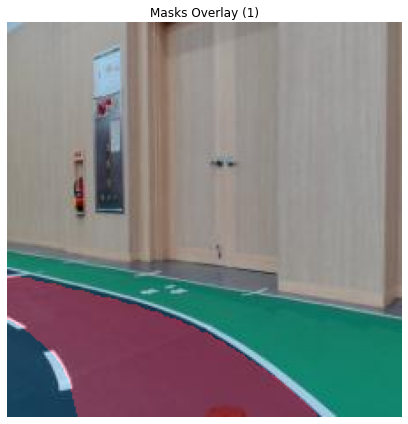

  Visualization: 478.4ms


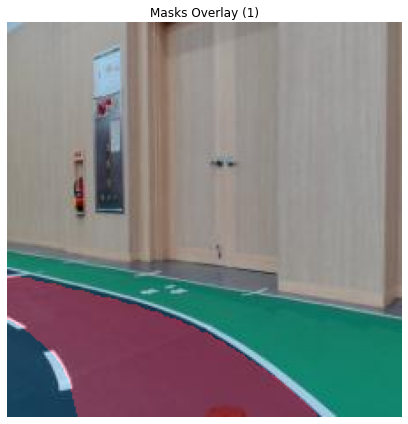

In [125]:
run(1, show=True)

Let's run it for 1 image and print out the detected label.

We can also run it for multiple images as shown below. In this example
we have only used 1 thread; in principle, users should be able to boost
the performance by employing more threads.

DPU Inference FPS: 16.9
Mask extraction timing:
Total FPS: 14.2


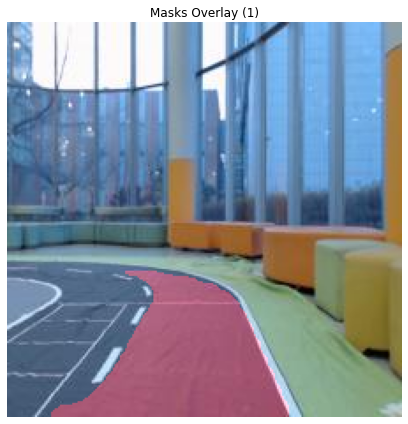

  Visualization: 599.6ms
DPU Inference FPS: 17.2
Mask extraction timing:
Total FPS: 14.5


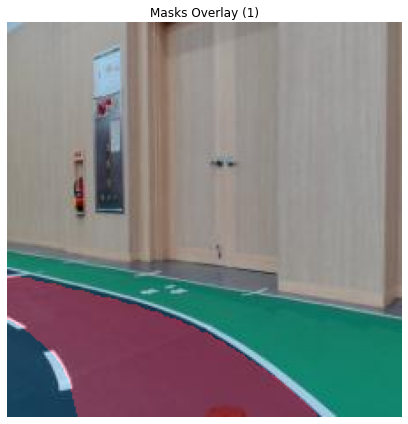

  Visualization: 477.0ms
DPU Inference FPS: 17.1
Mask extraction timing:
Total FPS: 14.5


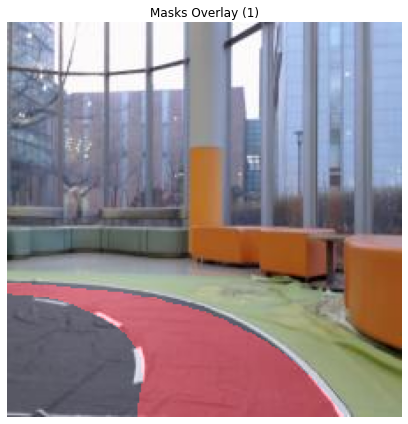

  Visualization: 596.1ms
DPU Inference FPS: 17.2
Mask extraction timing:
Total FPS: 14.5


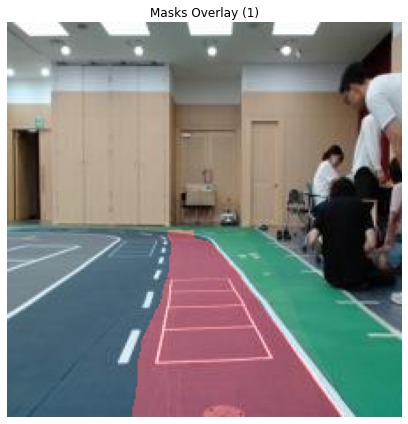

  Visualization: 577.2ms
DPU Inference FPS: 17.1
Mask extraction timing:
Total FPS: 14.0


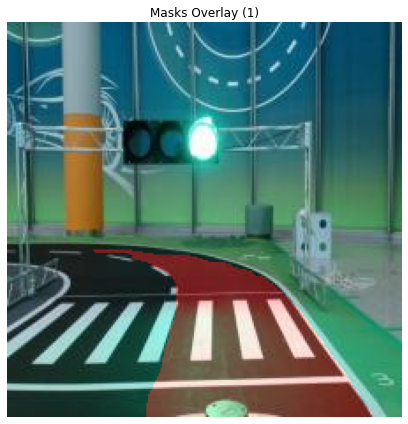

  Visualization: 691.4ms
DPU Inference FPS: 17.2
Mask extraction timing:
Total FPS: 14.5


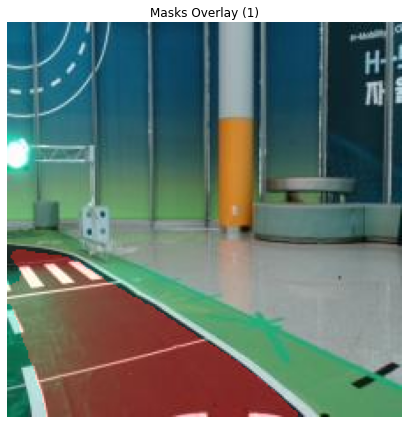

  Visualization: 595.0ms
DPU Inference FPS: 17.3
Mask extraction timing:
Total FPS: 14.6


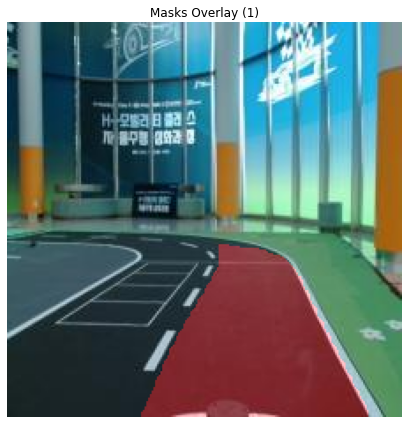

  Visualization: 592.9ms
DPU Inference FPS: 16.9
Mask extraction timing:
Total FPS: 14.3


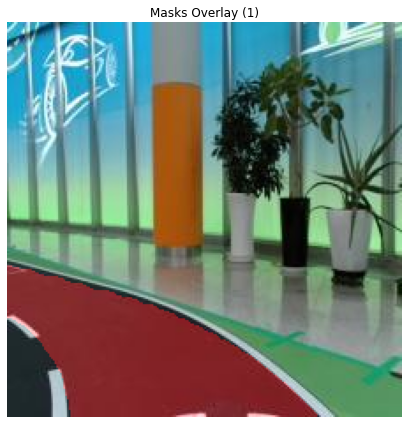

  Visualization: 2185.9ms
DPU Inference FPS: 17.1
Mask extraction timing:
Total FPS: 14.4


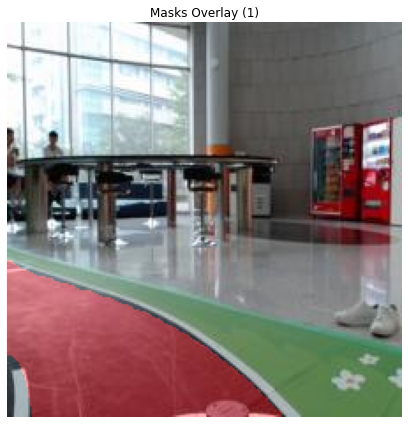

  Visualization: 618.1ms
DPU Inference FPS: 17.0
Mask extraction timing:
Total FPS: 14.4


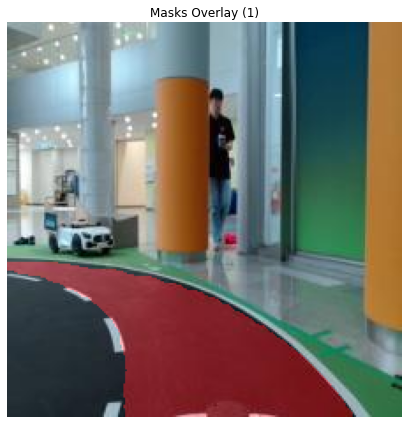

  Visualization: 558.4ms
Performance: 1.2205720214941298 FPS


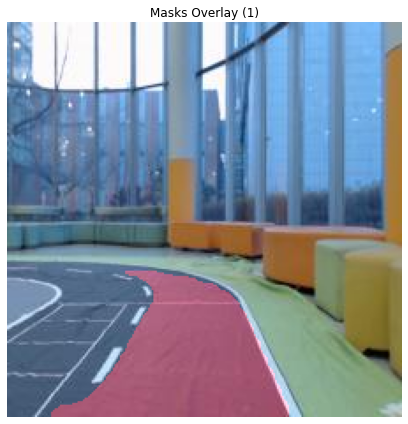

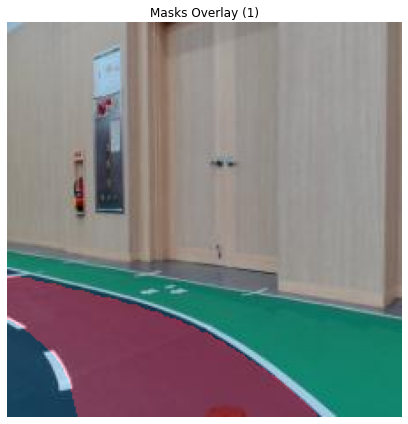

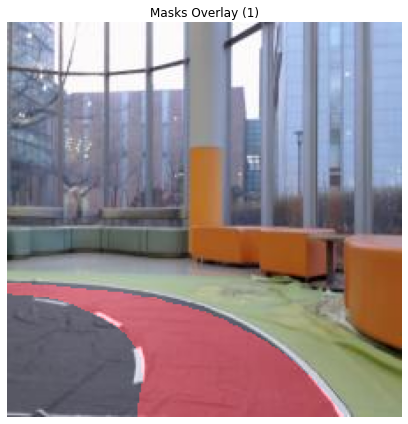

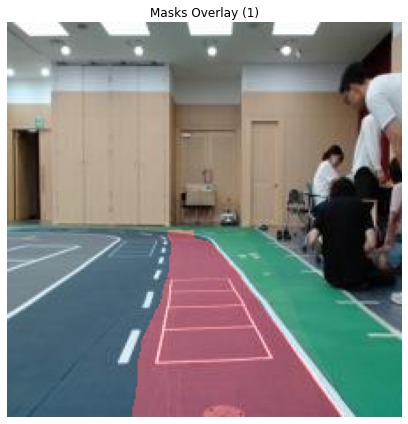

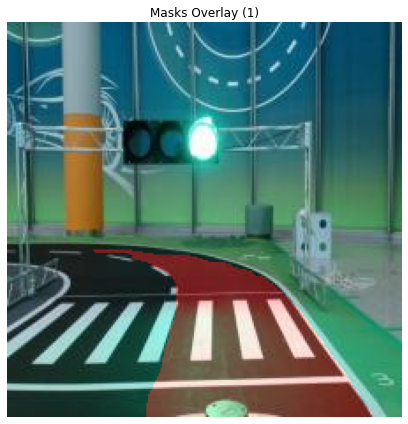

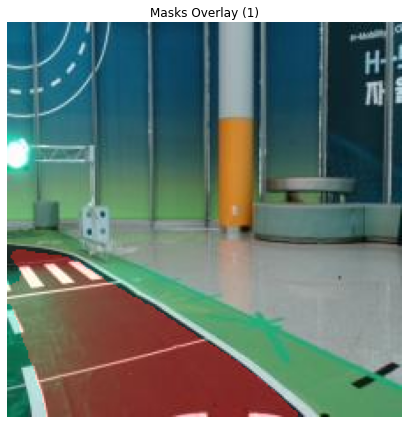

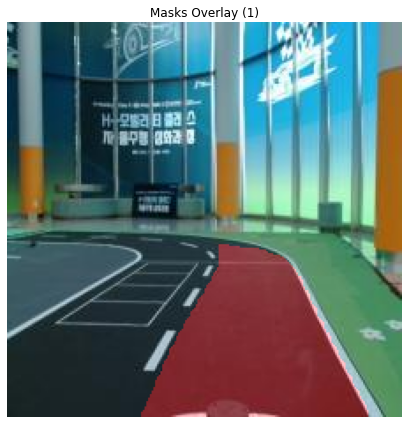

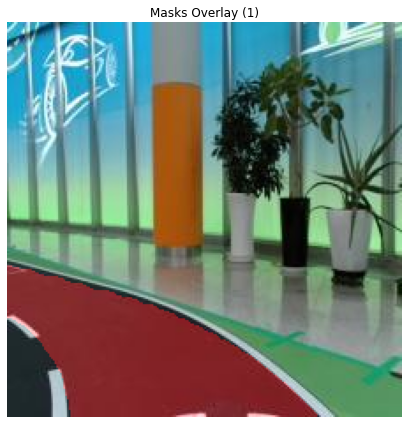

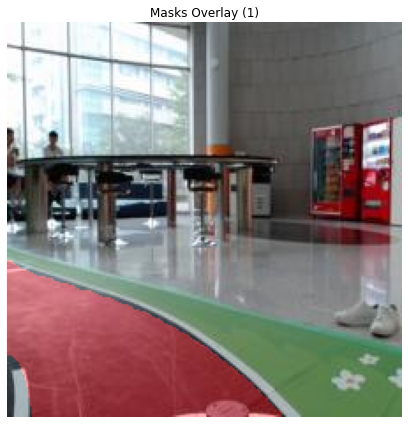

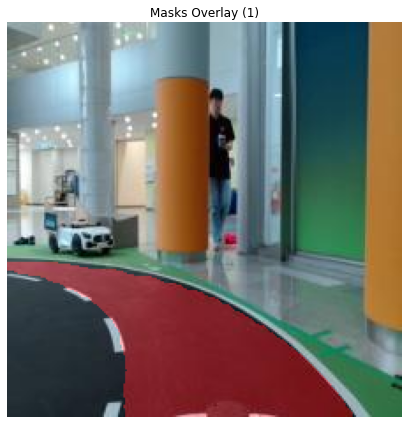

In [127]:
time1 = time.time()
[run(i) for i in range(total_images)]
time2 = time.time()
fps = total_images/(time2-time1)
print("Performance: {} FPS".format(fps))

In [ ]:
del overlay
del dpu

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----